<a href="https://colab.research.google.com/github/Ashu70/Ai_agents/blob/main/SQL_query_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL Query Agent

### Loading LLM

In [37]:
!pip install -qU langchain-google-genai
!pip install -qU langchain_community
!pip install -qU langgraph

In [38]:
# #I'm doing it Since mermaid.cli was not working. You don't need to do this

# !apt-get install -y npm
# !npm install -g mermaid.cli

# import tempfile
# import os
# from IPython.display import display, Image

# mermaid_code = graph.get_graph().draw_mermaid()

# # Create a temporary file for the PNG
# with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
#     png_file_path = tmpfile.name

# # Render Mermaid code to PNG using the CLI
# os.system(f"mmdc -i /dev/stdin -o {png_file_path} -t dark -b transparent <<<'{mermaid_code}'")

# # Display the PNG image
# display(Image(filename=png_file_path))

# # Optionally, clean up the temporary file
# os.remove(png_file_path)

In [39]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter Your API key : ")

##### Note - We are not using LangSmith API key here but if you want you can uncomment the below block

In [40]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
# os.environ["LANGSMITH_TRACING"] = "true"

#### Now we are initiating our model object

In [41]:
from langchain_google_genai import ChatGoogleGenerativeAI

#Since our goal is to generate SQL quries keeping temprature 0 makes more sense.

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

#### Testing my API connection

##### uncomment this if you want to test your API connection

In [42]:
# messages = [
#     ("system", "You are a helpful assistant that translates English to Hindi. Translate the user sentence."),
#     ("human", "I like building AI applications."),
# ]

# try:
#     ai_msg = llm.invoke(messages)
#     print(ai_msg.content) # access the string content of the message.
# except Exception as e:
#     print(f"Error: {e}")

#### The above indicates our API connection is successful

### Connecting to a SQL Data base

In [43]:
import requests

url = "https://github.com/Ashu70/Ai_agents/raw/refs/heads/main/Chinook.db"

response = requests.get(url)
if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [44]:
#To know about the data visit this link
#https://docs.yugabyte.com/preview/sample-data/chinook/

In [45]:
# #One other way to connect to DB without langchain

# !pip install -qU sqlalchemy
# from sqlalchemy import create_engine

# # Connect to the SQLite database
# engine = create_engine("sqlite:///Chinook.db")
# connection = engine.connect()

# # Now you can execute SQL queries
# # Example:
# # result = connection.execute("SELECT * FROM Customers LIMIT 5;")
# # for row in result:
# #     print(row)

# # Close the connection when finished
# connection.close()


In [46]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [47]:
db.dialect

'sqlite'

In [48]:
db.get_usable_table_names()

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [49]:
db.run("SELECT * FROM Employee LIMIT 5")

"[(1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com'), (2, 'Edwards', 'Nancy', 'Sales Manager', 1, '1958-12-08 00:00:00', '2002-05-01 00:00:00', '825 8 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 2T3', '+1 (403) 262-3443', '+1 (403) 262-3322', 'nancy@chinookcorp.com'), (3, 'Peacock', 'Jane', 'Sales Support Agent', 2, '1973-08-29 00:00:00', '2002-04-01 00:00:00', '1111 6 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 5M5', '+1 (403) 262-3443', '+1 (403) 262-6712', 'jane@chinookcorp.com'), (4, 'Park', 'Margaret', 'Sales Support Agent', 2, '1947-09-19 00:00:00', '2003-05-03 00:00:00', '683 10 Street SW', 'Calgary', 'AB', 'Canada', 'T2P 5G3', '+1 (403) 263-4423', '+1 (403) 263-4289', 'margaret@chinookcorp.com'), (5, 'Johnson', 'Steve', 'Sales Support Agent', 2, '1965-03-03 00:00:00', '2003-10-17 00:00:00', '7727B 41 Ave', 'Calgar

### Creating Application State

In [50]:
from typing import TypedDict, Annotated

In [51]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

### Importing Query prompt from langchain hub

In [52]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [53]:
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


In [54]:
from typing import Annotated

class QueryOutput(TypedDict):
    """Genrated SQL query"""

    query: Annotated[str, ..., "Syntactically correct and valid SQL query"]

QueryOutput({"query": "SELECT * FROM Employee Limit 2"})
QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'Syntactically correct and valid SQL query']}

In [55]:
query_prompt_template
#got idea what input varibables we need

ChatPromptTemplate(input_variables=['dialect', 'input', 'table_info', 'top_k'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'sql-query-system-prompt', 'lc_hub_commit_hash': '360a0e9d0f0f5da0ee9810a2a0ea3c9dc3de31b3ae9d50272420c33e48e6e323'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'table_info', 'top_k'], input_types={}, partial_variables={}, template='Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema

### Creating Query node

In [56]:
def write_query(state:State):
  """ Genereate SQL query to fetch information"""
  # Use .format() to populate the template
  prompt = query_prompt_template.invoke({
      "dialect":db.dialect,
      "table_info":db.get_table_info(),
      "top_k":"*",
      "input":state["question"]
  })

  structured_llm = llm.with_structured_output(QueryOutput)
  result = structured_llm.invoke(prompt)

  return {"query":result["query"]}

In [57]:
#write_query({"question": "How many employess are there?"})

### Creating Result node

In [58]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state:State):
  """Execute SQL query"""
  query = state["query"]
  execute_query_tool = QuerySQLDatabaseTool(db=db)

  return {'result': execute_query_tool.invoke({"query":query})}


In [59]:
execute_query({"query": "SELECT * FROM Employee Limit 2"})

{'result': "[(1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com'), (2, 'Edwards', 'Nancy', 'Sales Manager', 1, '1958-12-08 00:00:00', '2002-05-01 00:00:00', '825 8 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 2T3', '+1 (403) 262-3443', '+1 (403) 262-3322', 'nancy@chinookcorp.com')]"}

### Create Genrate Answer node

In [60]:
def genrate_answer(state:State):
  """ Genrate Answer using retrived information """
  prompt = (
      "From the given user Question, corresponding SQL query and SQL results answer the user question.\n"
      f'Question: {state["question"]}\n'
      f'SQL Query: {state["query"]}\n'
      f'SQL Results: {state["result"]}\n'
      "Answer:"
  )
  return {"answer": llm.invoke(prompt)}

In [61]:
#I'm doing it Since mermaid.cli was not working. You don't need to do this

!apt-get install -y npm
!npm install -g mermaid.cli

import tempfile
import os
from IPython.display import display, Image
from langgraph.graph import START, StateGraph # Import necessary modules

# Create and compile the StateGraph
graph_builder = StateGraph(State)

graph_builder.add_node(write_query, "Write Query")
graph_builder.add_node(execute_query, "Execute Query")
graph_builder.add_node(genrate_answer, "Genrate Answer")

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "genrate_answer")

graph = graph_builder.compile()

#Now Generate Mermaid code
mermaid_code = graph.get_graph().draw_mermaid()

# Create a temporary file for the PNG
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
    png_file_path = tmpfile.name

# Render Mermaid code to PNG using the CLI
os.system(f"mmdc -i /dev/stdin -o {png_file_path} -t dark -b transparent <<<'{mermaid_code}'")

# Display the PNG image
display(Image(filename=png_file_path))

# Optionally, clean up the temporary file
os.remove(png_file_path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
npm is already the newest version (8.5.1~ds-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
npm WARN deprecated inflight@1.0.6: This module is not supported, and leaks memory. Do not use it. Check out lru-cache if you want a good and tested way to coalesce async requests by a key value, which is much more comprehensive and powerful.
npm WARN deprecated rimraf@2.7.1: Rimraf versions prior to v4 are no longer supported
npm WARN deprecated glob@7.2.3: Glob versions prior to v9 are no longer supported
npm WARN deprecated puppeteer@1.20.0: < 22.8.2 is no longer supported
npm WARN deprecated mermaid.cli@0.5.1: This package is no longer being updated. Please use the @mermaid-js/mermaid-cli package instead.

changed 53 packages, and audited 54 packages in 16s

2 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities


In [62]:
question = "How many employess are there?"
query = write_query({"question": question})["query"]
result = execute_query({"query": query})["result"]
answer = genrate_answer({"question": question, "query": query, "result": result})["answer"]

print(answer.content)

There are 8 employees.


In [63]:
state = {"question": question, "query": query, "result": result}
state

{'question': 'How many employess are there?',
 'query': 'SELECT count(*) FROM Employee',
 'result': '[(8,)]'}

In [64]:
genrate_answer(state)
print(answer.content)

There are 8 employees.


### Building Graph

In [65]:
from langgraph.graph import START, StateGraph
from IPython.display import display, Image

graph_builder = StateGraph(State)

graph_builder.add_node(write_query, "Write Query")
graph_builder.add_node(execute_query, "Execute Query")
graph_builder.add_node(genrate_answer, "Genrate Answer")

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "genrate_answer")

graph = graph_builder.compile()

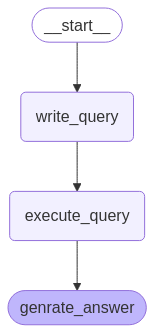

In [66]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
query = {'question': 'List all the ALbums dont limit'}
for step in graph.stream(query, stream_mode="updates"):
  print(step)

{'write_query': {'query': 'SELECT Title FROM Album'}}
{'execute_query': {'result': '[(\'For Those About To Rock We Salute You\',), (\'Balls to the Wall\',), (\'Restless and Wild\',), (\'Let There Be Rock\',), (\'Big Ones\',), (\'Jagged Little Pill\',), (\'Facelift\',), (\'Warner 25 Anos\',), (\'Plays Metallica By Four Cellos\',), (\'Audioslave\',), (\'Out Of Exile\',), (\'BackBeat Soundtrack\',), (\'The Best Of Billy Cobham\',), (\'Alcohol Fueled Brewtality Live! [Disc 1]\',), (\'Alcohol Fueled Brewtality Live! [Disc 2]\',), (\'Black Sabbath\',), (\'Black Sabbath Vol. 4 (Remaster)\',), (\'Body Count\',), (\'Chemical Wedding\',), (\'The Best Of Buddy Guy - The Millenium Collection\',), (\'Prenda Minha\',), (\'Sozinho Remix Ao Vivo\',), (\'Minha Historia\',), (\'Afrociberdelia\',), (\'Da Lama Ao Caos\',), (\'Acústico MTV [Live]\',), (\'Cidade Negra - Hits\',), (\'Na Pista\',), (\'Axé Bahia 2001\',), (\'BBC Sessions [Disc 1] [Live]\',), (\'Bongo Fury\',), (\'Carnaval 2001\',), (\'Chill: B

## Creating Agent now

In [68]:
#The problem with above approach is that, even if the Question is wrong the Query will get executed and we will get wrong answer but with agents we will solve this problem and many of like this.

### Setting up Agent Prompt

In [69]:
#Read the prompt from langchain hub to understand it's working

In [70]:
from langchain import hub
prompt = hub.pull("langchain-ai/sql-agent-system-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [71]:
prompt.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [72]:
system_prompt = prompt.invoke({'dialect':db.dialect, 'top_k':5})